## PRUEBA DE MODELOS

In [1]:
!python --version#Era 3.7.10

Python 3.10.12


In [ ]:
#!pip install -r ../../requirements.txt
!pip install pyarrow
!pip install tsfel
!pip install imblearn
!pip install lightgbm
!pip install tensorflow
!pip install catboost
!pip install boruta

In [1]:
import os
import pandas as pd
import numpy as np
import warnings
import boto3
import io
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.5f}'.format #evita que muestre notacion cientifica
# pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import os
module_path = os.path.abspath(os.path.join('../../'))
nombre_carpeta = '../../data/2022'
import sys
if module_path not in sys.path:
    sys.path.append(module_path)
from src.preprocessing.preprocessing  import llenar_val_vacios_str,llenar_val_vacios_ciclo,TsfelVars, ExtraVars,ToDummy, TeEncoder, CardinalityReducer
from src.modeling.simple_models import ChangeTrendPercentajeIdentifierWide,ConstantConsumptionClassifierWide
from src.modeling.supervised_models import LGBMModel, NNModel, LSTMNNModel
from src.modeling.feature_selection import feature_selection_by_constant, feature_selection_by_boruta, feature_selection_by_correlation
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score, f1_score, precision_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import _pickle as pickle

Matplotlib is building the font cache; this may take a moment.


In [4]:
## CARGAR DATATASETS PREPROCESADOS PARA LOS MODELOS
carpeta=nombre_carpeta+'/dataset_nuevo/'#_extendido
feat_selec = pd.read_parquet(carpeta+'feat_selec.parquet')
X_train = pd.read_parquet(carpeta+'X_train.parquet')
y_train_aux = pd.read_parquet(carpeta+'y_train.parquet')
y_train = y_train_aux['target']
X_val = pd.read_parquet(carpeta+'X_val.parquet')
y_val_aux = pd.read_parquet(carpeta+'y_val.parquet')
y_val = y_val_aux['target']
X_test = pd.read_parquet(carpeta+'X_test.parquet')
y_test_aux = pd.read_parquet(carpeta+'y_test.parquet')
y_test = y_test_aux['target']

variables_consumo = [x for x in X_train.columns if '_anterior' in x]# and x!='0_anterior'
variables_categoricas = ['cant_consumo_est','cant_estado_0','cant_estado_1','cant_estado_2','cant_estado_3','cant_estado_4','mes','bimestre','trimestre','cuatrimestre','semestre','cant_categorias','ult_categoria','categ_mas_frecuente','cambios_categoria']
cols_excluir = ['index','instalacion','date_fiscalizacion'] + variables_consumo + variables_categoricas
cols_for_feature_sel = [x for x in X_train.columns if x not in cols_excluir]

feauture_selected = select_by_boruta = feat_selec['boruta'][0].tolist()
select_by_corr = feat_selec['corr'][0].tolist()
select_by_constant = feat_selec['constant'][0].tolist()
cols_for_model = variables_categoricas+variables_consumo+feauture_selected

In [5]:
X_train.head()

,instalacion,12_anterior,11_anterior,10_anterior,9_anterior,8_anterior,7_anterior,6_anterior,5_anterior,4_anterior,3_anterior,2_anterior,1_anterior,0_anterior,date_fiscalizacion,cant_consumo_est,cant_estado_0,cant_estado_1,cant_estado_2,cant_estado_3,cant_estado_4,mes,bimestre,trimestre,cuatrimestre,semestre,cant_categorias,ult_categoria,categ_mas_frecuente,cambios_categoria,index,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,0_ECDF_1,0_ECDF_2,0_ECDF_3,0_ECDF_4,0_ECDF_5,0_ECDF_6,0_ECDF_7,0_ECDF_8,0_ECDF_9,0_Histogram_0,0_Histogram_1,0_Histogram_2,0_Histogram_3,0_Histogram_4,0_Histogram_5,0_Histogram_6,0_Histogram_7,0_Histogram_8,0_Histogram_9,0_Interquartile range,0_Kurtosis,0_Max,0_Mean,0_Mean absolute deviation,0_Median,0_Median absolute deviation,0_Min,0_Root mean square,0_Skewness,0_Standard deviation,0_Variance,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Centroid,0_Entropy,0_Mean absolute diff,0_Mean diff,0_Median absolute diff,0_Median diff,0_Negative turning points,0_Neighbourhood peaks,0_Peak to peak distance,0_Positive turning points,0_Signal distance,0_Slope,0_Sum absolute diff,0_Total energy,0_Zero crossing rate,mean_3,cant_ceros_3,max_cant_ceros_seg_3,slope_3,min_cons3,max_cons3,std_cons3,var_cons3,skew_cons3,mean_6,cant_ceros_6,max_cant_ceros_seg_6,slope_6,min_cons6,max_cons6,std_cons6,var_cons6,skew_cons6,kurt_cons6,mean_12,cant_ceros_12,max_cant_ceros_seg_12,slope_12,min_cons12,max_cons12,std_cons12,var_cons12,skew_cons12,kurt_cons12
14075,50541101,37.00000,28.00000,22.00000,25.00000,28.00000,24.00000,17.00000,23.00000,27.00000,21.00000,14.00000,12.00000,46.00000,2022-01-01,0,0,10,0,2,0,1,1,1,1,1,1,DOM,DOM,0,14075,2.00000,9.00000,14.00000,27.00000,0.08333,0.16667,0.25000,0.33333,0.41667,0.50000,0.58333,0.66667,0.75000,0.83333,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,7.25000,-0.13500,37.00000,23.16667,5.00000,23.50000,4.00000,12.00000,24.06588,0.15870,6.51707,42.47222,6950.00000,2.53500,6950.00000,0.04090,0.95351,5.18182,-2.27273,6.00000,-4.00000,2.00000,0.00000,25.00000,2.00000,58.25264,-1.46853,57.00000,63181.81818,0.00000,15.66667,0,0,-4.50000,12.00000,21.00000,4.72582,22.33333,1.38964,19.00000,0,0,-1.65714,12.00000,27.00000,5.69210,32.40000,0.17568,-1.30887,23.16667,0,0,-1.46853,12.00000,37.00000,6.80686,46.33333,0.18233,0.51883
9393,50388886,58.00000,85.00000,52.00000,24.00000,3.00000,3.00000,4.00000,4.00000,4.00000,2.00000,2.00000,2.00000,1.00000,2022-03-01,0,1,10,0,1,0,3,2,1,1,1,3,COM,COM,4,9393,2.00000,9.00000,2.00000,24.00000,0.08333,0.16667,0.25000,0.33333,0.41667,0.50000,0.58333,0.66667,0.75000,0.83333,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,28.25000,0.14369,85.00000,20.25000,23.00000,4.00000,2.00000,2.00000,34.09179,1.27628,27.42604,752.18750,13947.00000,2.13000,13947.00000,0.01068,0.73245,10.18182,-5.09091,1.00000,0.00000,0.00000,0.00000,83.00000,1.00000,117.72559,-6.32517,112.00000,126790.90909,0.00000,2.00000,0,0,0.00000,2.00000,2.00000,0.00000,0.00000,0.00000,3.00000,0,0,-0.51429,2.00000,4.00000,1.09545,1.20000,0.00000,-3.33333,20.25000,0,0,-6.32517,2.00000,85.00000,28.64556,820.56818,1.46634,0.96163
2899,50036226,20.00000,22.00000,25.00000,26.00000,39.00000,39.00000,26.00000,26.00000,27.00000,46.00000,8.00000,1.00000,25.00000,2022-02-01,0,0,11,0,0,0,2,1,1,1,1,1,DOM,DOM,0,2899,2.00000,9.00000,8.00000,27.00000,0.08333,0.16667,0.25000,0.33333,0.41667,0.50000,0.58333,0.66667,0.75000,0.83333,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,8.50000,-0.23147,46.00000,25.41667,8.51389,26.00000,5.00000,1.00000,28.12028,-0.30153,12.03092,144.74306,9489.00000,2.94500,9489.00000,0.05455,0.84298,8.81818,-1.72727,3.00000,1.00000,0.00000,0.00000,45.00000,1.00000,100.41410,-0.82168,97.00000,86263.63636,0.00000,18.33333,0,0,-22.50000,1.00000,46.00000,24.21432,586.33333,1.57063,22.33333,0,0,-4.57143,1.00000,46.00000,15.93319,253.86667,

In [2]:
# ARMAMOS DATASET Y FEATURE SELECTION CON REGISTROS ACTUALES PARA TRAIN/VAL/TEST
df = pd.read_parquet(os.path.join(nombre_carpeta, 'data_complete_wide_features.parquet'))
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

variables_consumo = [x for x in X_train.columns if '_anterior' in x]# and x!='0_anterior'
variables_categoricas = ['cant_consumo_est','cant_estado_0','cant_estado_1','cant_estado_2','cant_estado_3','cant_estado_4','mes','bimestre','trimestre','cuatrimestre','semestre','cant_categorias','ult_categoria','categ_mas_frecuente','cambios_categoria']
cols_excluir = ['index','instalacion','date_fiscalizacion'] + variables_consumo + variables_categoricas
cols_for_feature_sel = [x for x in X_train.columns if x not in cols_excluir]

select_by_constant = feature_selection_by_constant(X_train, y_train, cols_for_feature_sel, th=0.99)
select_by_corr = feature_selection_by_correlation(X_train, y_train, select_by_constant,method='pearson', th=0.95)
select_by_boruta = feature_selection_by_boruta(X_train[select_by_constant], y_train, N=5)
print(f" # variables No constantes {len(select_by_constant)}")
print(f" # variables No correlacionadas {len(select_by_corr)}")
print(f" # variables seleccionadas por Boruta : {len(select_by_boruta)}")
feat_selec = pd.DataFrame({'constant':[select_by_constant],'corr':[select_by_corr],'boruta':[select_by_boruta]})

carpeta=nombre_carpeta+'/dataset_nuevo/'#_extendido
feat_selec.to_parquet(carpeta+'feat_selec.parquet')
X_train.to_parquet(carpeta+'X_train.parquet')
X_val.to_parquet(carpeta+'X_val.parquet')
X_test.to_parquet(carpeta+'X_test.parquet')
y_train_guardar = pd.DataFrame(y_train)
y_train_guardar.to_parquet(carpeta+'y_train.parquet')
y_val_guardar = pd.DataFrame(y_val)
y_val_guardar.to_parquet(carpeta+'y_val.parquet')
y_test_guardar = pd.DataFrame(y_test)
y_test_guardar.to_parquet(carpeta+'y_test.parquet')

Calculando Correlación Entre Variables
Eliminando Variables Altamente Correlacionadas


100%|██████████| 5/5 [07:43<00:00, 92.67s/it]


 # variables No constantes 64
 # variables No correlacionadas 41
 # variables seleccionadas por Boruta : 40


## LGBM

In [3]:
# Definimos las variables finales para el entrenamiento de los modelos.
feauture_selected = select_by_boruta
cols_for_model = variables_categoricas+variables_consumo[:-1]+feauture_selected

# Definimos el metodo de balanceo de clases con su correspondiente umbral y el pipeline de pre-procesamiento de variables categoricas.
param_imb_method = 'over'#under
sam_th = 1#1
periodo = 12
preprocesor = 1 # Pipeline de variables categoricas
resulado_final = {} # para guardar todas las metricas obtenidas

In [ ]:
!pip install lightgbm==3.3.2

In [ ]:
%%time
train_lgbm_model = LGBMModel(cols_for_model,
                             hyperparams=None,
                             search_hip=True,
                             sampling_th = sam_th,
                             preprocesor_num = preprocesor,
                             sampling_method=param_imb_method)
lgbm_model = train_lgbm_model.train(X_train,y_train,X_val, y_val)

In [6]:
print(f'{X_train.shape} {y_train.shape} {X_val.shape} {y_val.shape}')

(28492, 114) (28492,) (7123, 114) (7123,)


In [7]:
#y_pred_lgbm = lgbm_model.predict(df_test[cols_for_model])
y_pred_test_lgbm = lgbm_model.predict_proba(X_test[cols_for_model])[:,1]>=0.6

print('Reporte para LGBM:')
print(classification_report(y_test, y_pred_test_lgbm))
#roc_curve(y_test, y_pred_test_lgbm).plot()

Reporte para LGBM:
              precision    recall  f1-score   support

           0       0.99      0.81      0.89      8548
           1       0.16      0.86      0.27       356

    accuracy                           0.81      8904
   macro avg       0.58      0.83      0.58      8904
weighted avg       0.96      0.81      0.87      8904



In [8]:
y_pred_test_lgbm = lgbm_model.predict_proba(X_test[cols_for_model])[:,1]
resulado_final[f'{param_imb_method}-lgbm'] = y_pred_test_lgbm
print("AUC Test:  %.3f" %  roc_auc_score(y_test,y_pred_test_lgbm))

AUC Test:  0.920


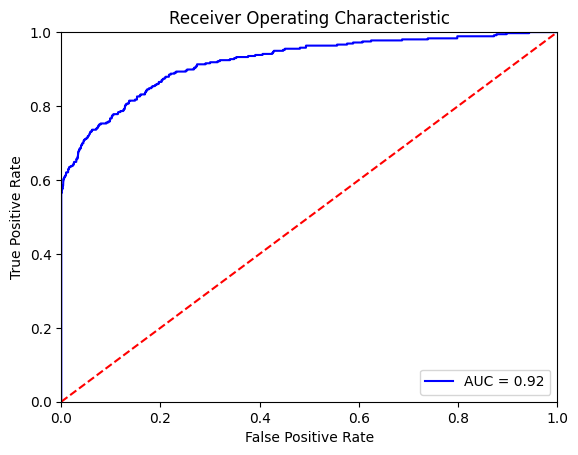

In [9]:
import sklearn.metrics as metrics
preds = y_pred_test_lgbm
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

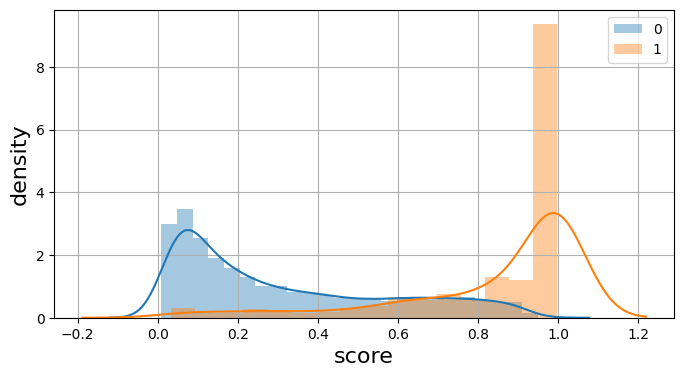

In [10]:
plt.figure(figsize=(8,4))
sns.distplot(y_pred_test_lgbm[y_test==0], label='0')
sns.distplot(y_pred_test_lgbm[y_test==1], label='1')
plt.xlabel('score', fontsize=16)
plt.ylabel('density', fontsize=16)
plt.legend()
plt.grid()

## PRUEBA DE CASOS ESPECÍFICOS

In [12]:
index_raros = np.where(y_pred_test_lgbm>0.99)
x_raros = X_test[y_pred_test_lgbm>0.99]
print(f'{len(index_raros[0])} {x_raros.shape}')
x_raros.head(5)

201 (201, 114)


,instalacion,12_anterior,11_anterior,10_anterior,9_anterior,8_anterior,7_anterior,6_anterior,5_anterior,4_anterior,3_anterior,2_anterior,1_anterior,0_anterior,date_fiscalizacion,cant_consumo_est,cant_estado_0,cant_estado_1,cant_estado_2,cant_estado_3,cant_estado_4,mes,bimestre,trimestre,cuatrimestre,semestre,cant_categorias,ult_categoria,categ_mas_frecuente,cambios_categoria,index,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,0_ECDF_1,0_ECDF_2,0_ECDF_3,0_ECDF_4,0_ECDF_5,0_ECDF_6,0_ECDF_7,0_ECDF_8,0_ECDF_9,0_Histogram_0,0_Histogram_1,0_Histogram_2,0_Histogram_3,0_Histogram_4,0_Histogram_5,0_Histogram_6,0_Histogram_7,0_Histogram_8,0_Histogram_9,0_Interquartile range,0_Kurtosis,0_Max,0_Mean,0_Mean absolute deviation,0_Median,0_Median absolute deviation,0_Min,0_Root mean square,0_Skewness,0_Standard deviation,0_Variance,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Centroid,0_Entropy,0_Mean absolute diff,0_Mean diff,0_Median absolute diff,0_Median diff,0_Negative turning points,0_Neighbourhood peaks,0_Peak to peak distance,0_Positive turning points,0_Signal distance,0_Slope,0_Sum absolute diff,0_Total energy,0_Zero crossing rate,mean_3,cant_ceros_3,max_cant_ceros_seg_3,slope_3,min_cons3,max_cons3,std_cons3,var_cons3,skew_cons3,mean_6,cant_ceros_6,max_cant_ceros_seg_6,slope_6,min_cons6,max_cons6,std_cons6,var_cons6,skew_cons6,kurt_cons6,mean_12,cant_ceros_12,max_cant_ceros_seg_12,slope_12,min_cons12,max_cons12,std_cons12,var_cons12,skew_cons12,kurt_cons12
44247,50279899,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,25.00000,25.00000,25.00000,25.00000,25.00000,25.00000,2022-08-01,2,1,9,0,1,1,8,4,3,2,2,2,DOM,DOM,2,44247,2.00000,9.00000,0.00000,25.00000,0.08333,0.16667,0.25000,0.33333,0.41667,0.50000,0.58333,0.66667,0.75000,0.83333,0.00000,0.00000,0.00000,0.00000,0.00000,7.00000,0.00000,0.00000,0.00000,0.00000,25.00000,-1.88571,25.00000,10.41667,12.15278,0.00000,0.00000,0.00000,16.13743,0.33806,12.32517,151.90972,3125.00000,1.12500,3125.00000,0.09000,0.27333,2.27273,2.27273,0.00000,0.00000,0.00000,0.00000,25.00000,0.00000,35.01999,3.05944,25.00000,28409.09091,1.00000,25.00000,0,0,0.00000,25.00000,25.00000,0.00000,0.00000,0.00000,20.83333,1,0,3.57143,0.00000,25.00000,10.20621,104.16667,-2.44949,6.00000,10.41667,7,7,3.05944,0.00000,25.00000,12.87322,165.71970,0.38840,-2.26286
43100,50192413,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2022-03-01,1,0,11,0,1,0,3,2,1,1,1,2,DOM,DOM,2,43100,0.00000,0.00000,0.00000,0.00000,0.08333,0.16667,0.25000,0.33333,0.41667,0.50000,0.58333,0.66667,0.75000,0.83333,0.00000,0.00000,0.00000,0.00000,0.00000,12.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-3.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,11.00000,0.00000,0.00000,0.00000,0.00000,0.00000,3,3,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,6,6,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,12,12,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
44073,50023700,63.00000,61.00000,60.00000,59.00000,59.00000,60.00000,60.00000,60.00000,60.00000,60.00000,60.00000,60.00000,60.00000,2022-08-01,3,0,10,0,2,0,8,4,3,2,2,2,COM,COM,2,44073,2.00000,9.00000,59.00000,60.00000,0.08333,0.16667,0.25000,0.33333,0.41667,0.50000,0.58333,0.66667,0.75000,0.83333,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,3.05143,63.00000,60.16667,0.61111,60.00000,0.00000,59.00000,60.17475,1.74826,0.98601,0.97222,43452.00000,6.60500,43452.00000,0.05452,0.39562,0.45455,-0.27273,0.00000,0.00000,0.00000,0.00000,4.00000,0.00000,13.47871,-0.11888,5.00000,395018.18182,0.00000,60.00000,0,0,0.00000,60.00000,60.00000,0.00000,0.00000,0.00000,60.00000,0,0,-0.00000,60.00000,60.00000,0.00000,0.00000,0.00000,0.00000,60.16667,0,0,-0.11888,59.00000,63.0

['12_anterior', '11_anterior', '10_anterior', '9_anterior', '8_anterior', '7_anterior', '6_anterior', '5_anterior', '4_anterior', '3_anterior', '2_anterior', '1_anterior', '0_anterior']


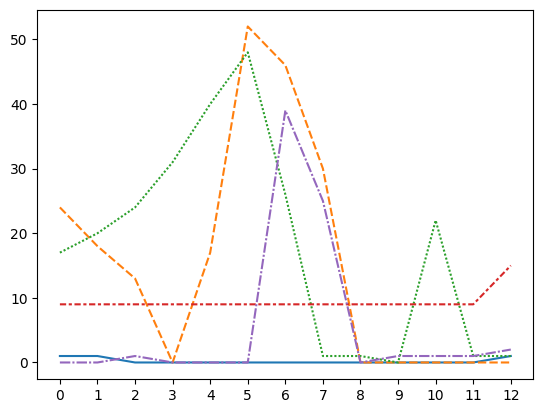

In [81]:
data=x_raros[variables_consumo].head(5).transpose()
g = sns.lineplot(data=data,legend=False)
g.set_xticks(range(len(data))) # <--- set the ticks first
g.set_xticklabels(range(len(data)))
print(variables_consumo)

In [13]:
index_raros = np.where(y_pred_test_lgbm<0.1)
x_raros = X_test[y_pred_test_lgbm<0.1]
print(f'{len(index_raros[0])} {x_raros.shape}')
x_raros.head(5)

2492 (2492, 114)


,instalacion,12_anterior,11_anterior,10_anterior,9_anterior,8_anterior,7_anterior,6_anterior,5_anterior,4_anterior,3_anterior,2_anterior,1_anterior,0_anterior,date_fiscalizacion,cant_consumo_est,cant_estado_0,cant_estado_1,cant_estado_2,cant_estado_3,cant_estado_4,mes,bimestre,trimestre,cuatrimestre,semestre,cant_categorias,ult_categoria,categ_mas_frecuente,cambios_categoria,index,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,0_ECDF_1,0_ECDF_2,0_ECDF_3,0_ECDF_4,0_ECDF_5,0_ECDF_6,0_ECDF_7,0_ECDF_8,0_ECDF_9,0_Histogram_0,0_Histogram_1,0_Histogram_2,0_Histogram_3,0_Histogram_4,0_Histogram_5,0_Histogram_6,0_Histogram_7,0_Histogram_8,0_Histogram_9,0_Interquartile range,0_Kurtosis,0_Max,0_Mean,0_Mean absolute deviation,0_Median,0_Median absolute deviation,0_Min,0_Root mean square,0_Skewness,0_Standard deviation,0_Variance,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Centroid,0_Entropy,0_Mean absolute diff,0_Mean diff,0_Median absolute diff,0_Median diff,0_Negative turning points,0_Neighbourhood peaks,0_Peak to peak distance,0_Positive turning points,0_Signal distance,0_Slope,0_Sum absolute diff,0_Total energy,0_Zero crossing rate,mean_3,cant_ceros_3,max_cant_ceros_seg_3,slope_3,min_cons3,max_cons3,std_cons3,var_cons3,skew_cons3,mean_6,cant_ceros_6,max_cant_ceros_seg_6,slope_6,min_cons6,max_cons6,std_cons6,var_cons6,skew_cons6,kurt_cons6,mean_12,cant_ceros_12,max_cant_ceros_seg_12,slope_12,min_cons12,max_cons12,std_cons12,var_cons12,skew_cons12,kurt_cons12
15538,50193687,5.00000,9.00000,11.00000,13.00000,16.00000,14.00000,19.00000,22.00000,6.00000,12.00000,12.00000,14.00000,26.00000,2022-12-01,0,3,6,0,0,3,12,6,4,3,2,2,DOM,DOM,2,15538,2.00000,9.00000,6.00000,14.00000,0.08333,0.16667,0.25000,0.33333,0.41667,0.50000,0.58333,0.66667,0.75000,0.83333,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,4.00000,-0.40816,22.00000,12.75000,3.58333,12.50000,2.50000,5.00000,13.58001,0.19729,4.67484,21.85417,2213.00000,1.43500,2213.00000,0.06131,0.90702,4.09091,0.81818,3.00000,2.00000,2.00000,0.00000,17.00000,2.00000,47.60493,0.42308,45.00000,20118.18182,0.00000,12.66667,0,0,1.00000,12.00000,14.00000,1.15470,1.33333,1.73205,14.16667,0,0,-1.40000,6.00000,22.00000,5.67157,32.16667,0.04696,-0.29442,12.75000,0,0,0.42308,5.00000,22.00000,4.88272,23.84091,0.22667,0.08481
11131,50032426,10.00000,11.00000,11.00000,13.00000,12.00000,8.00000,0.00000,0.00000,0.00000,0.00000,0.00000,5.00000,12.00000,2022-01-01,0,1,11,0,0,0,1,1,1,1,1,2,DOM,DOM,2,11131,2.00000,9.00000,0.00000,11.00000,0.08333,0.16667,0.25000,0.33333,0.41667,0.50000,0.58333,0.66667,0.75000,0.83333,0.00000,0.00000,0.00000,0.00000,0.00000,5.00000,0.00000,0.00000,0.00000,0.00000,11.00000,-1.76215,13.00000,5.83333,5.00000,6.50000,6.00000,0.00000,7.87401,-0.01809,5.28888,27.97222,744.00000,0.62500,744.00000,0.02743,0.68364,1.90909,-0.45455,1.00000,0.00000,0.00000,0.00000,13.00000,1.00000,27.34888,-1.18881,21.00000,6763.63636,2.00000,1.66667,2,2,2.50000,0.00000,5.00000,2.88675,8.33333,1.73205,0.83333,5,5,0.71429,0.00000,5.00000,2.04124,4.16667,2.44949,6.00000,5.83333,5,5,-1.18881,0.00000,13.00000,5.52405,30.51515,-0.02078,-2.06652
37133,50061357,36.00000,38.00000,38.00000,37.00000,35.00000,43.00000,41.00000,34.00000,34.00000,34.00000,24.00000,45.00000,35.00000,2022-08-01,0,1,8,0,1,2,8,4,3,2,2,2,COM,COM,4,37133,2.00000,9.00000,34.00000,38.00000,0.08333,0.16667,0.25000,0.33333,0.41667,0.50000,0.58333,0.66667,0.75000,0.83333,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,4.75000,0.86082,45.00000,36.58333,3.75000,36.50000,2.50000,24.00000,36.94252,-0.67294,5.13904,26.40972,16377.00000,3.98500,16377.00000,0.05401,0.84298,4.81818,0.81818,2.00000,0.00000,2.00000,0.00000,21.00000,1.00000,57.32941,-0.26224,53.00000,148881.81818,0.00000,34.33333,0,0,5.50000,24.00000,45.00000,10.50397,110.33333,0.14266,35.33333,0,0,-0.28571,24.00000,45.00000,7.20185,51.86667,-0.30323,0.58579,36.583

['12_anterior', '11_anterior', '10_anterior', '9_anterior', '8_anterior', '7_anterior', '6_anterior', '5_anterior', '4_anterior', '3_anterior', '2_anterior', '1_anterior', '0_anterior']


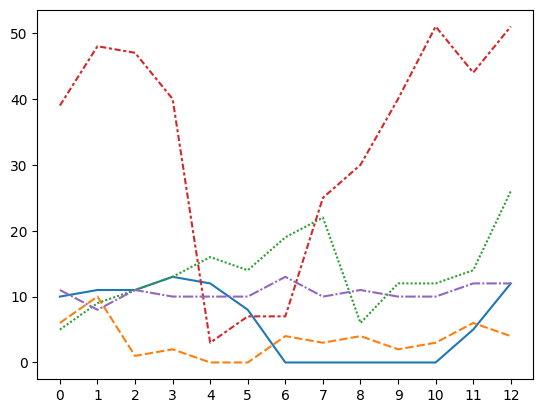

In [83]:
data=x_raros[variables_consumo].head(5).transpose()
g = sns.lineplot(data=data,legend=False)
g.set_xticks(range(len(data))) # <--- set the ticks first
g.set_xticklabels(range(len(data)))
print(variables_consumo)

## EVALUACIÓN POR MES PARA VERIFICAR NIVELES DE PRECISION

In [41]:
lis = X_test.mes.astype(int).unique().tolist()#.sort(reverse=True)
lis.sort()
for mes in lis:
    y_pred_test_lgbm = lgbm_model.predict_proba(X_test.query(f'mes=={mes}')[cols_for_model])[:,1]
    y_test_mes = y_test[X_test['mes']==mes]
    print(f"Mes {mes}: N={len(y_test_mes)}, Fraudes={y_test_mes.sum()}, AUC Test:  {roc_auc_score(y_test_mes,y_pred_test_lgbm):.3f}")

Mes 1: N=777, Fraudes=4, AUC Test:  0.855
Mes 2: N=906, Fraudes=48, AUC Test:  0.817
Mes 3: N=879, Fraudes=66, AUC Test:  0.848
Mes 4: N=838, Fraudes=13, AUC Test:  0.923
Mes 5: N=815, Fraudes=6, AUC Test:  0.602
Mes 6: N=932, Fraudes=62, AUC Test:  0.791
Mes 7: N=683, Fraudes=37, AUC Test:  0.876
Mes 8: N=745, Fraudes=71, AUC Test:  0.960
Mes 9: N=730, Fraudes=24, AUC Test:  0.839
Mes 10: N=554, Fraudes=20, AUC Test:  0.950
Mes 11: N=544, Fraudes=4, AUC Test:  1.000
Mes 12: N=501, Fraudes=1, AUC Test:  1.000


## RNN - MULTILAYER PERCEPTRON

In [13]:
# Definimos el metodo de balanceo de clases con su correspondiente umbral y el pipeline de pre-procesamiento de variables categoricas.
param_imb_method = 'over'
sam_th = 1#0.8
periodo = 12
preprocesor = 1 # Pipeline de variables categoricas
resulado_final = {} # para guardar todas las metricas obtenidas

In [14]:
# Definimos las variables finales para el entrenamiento de los modelos.
feauture_selected = select_by_boruta
cols_for_model = variables_categoricas+variables_consumo+feauture_selected

In [15]:
%%time
features_names = variables_categoricas+feauture_selected
spents_names = variables_consumo
train_nn_model = NNModel(features_names,spents_names,sampling_th = sam_th,preprocesor_num = preprocesor,sampling_method=param_imb_method)
rnn_model,pipe_features,pipe_spent = train_nn_model.train(X_train,y_train,X_val,y_val)

2023-05-19 19:24:51.330917: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-19 19:24:51.330967: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-81-100.ec2.internal): /proc/driver/nvidia/version does not exist
2023-05-19 19:24:51.331532: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Restoring model weights from the end of the best epoch: 3.
Epoch 53: early stopping
CPU times: user 1min 5s, sys: 3.28 s, total: 1min 8s
Wall time: 12.4 s


In [16]:
X_test_features = pipe_features.transform(X_test[features_names])
X_test_spents = pipe_spent.transform(X_test[spents_names])
X_test_features = np.concatenate([X_test_features,X_test_spents],axis=1)

In [17]:
y_pred_test_rnn = rnn_model.predict(X_test_features, batch_size=train_nn_model.BATCH_SIZE)#X_test[variables_categoricas+variables_consumo+select_by_boruta]
resulado_final[f'{param_imb_method}-ffn'] = y_pred_test_rnn
print("AUC Test:  %.3f" %  roc_auc_score(y_test,y_pred_test_rnn))

5/5 [==============================] - 0s 2ms/step
AUC Test:  0.912


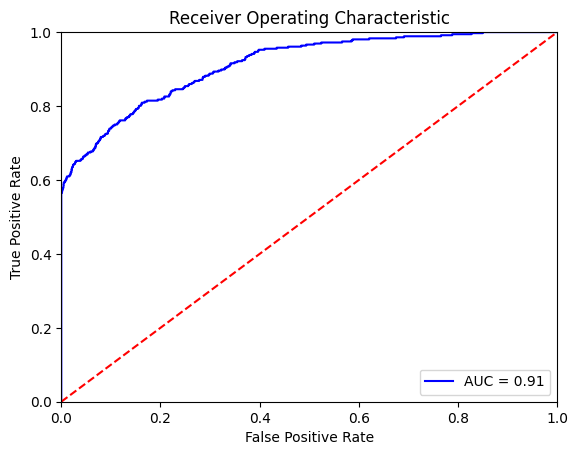

In [18]:
import sklearn.metrics as metrics
preds = y_pred_test_rnn
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

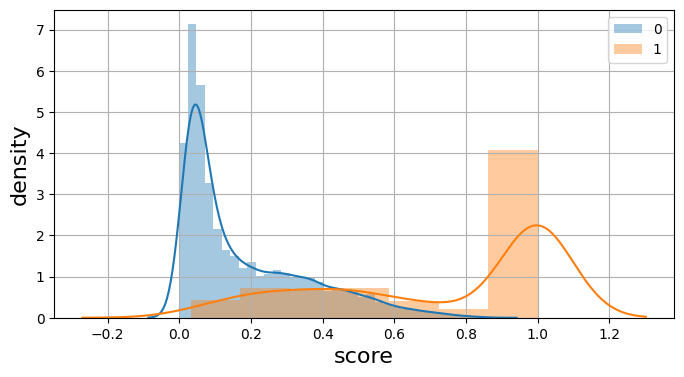

In [19]:
plt.figure(figsize=(8,4))
sns.distplot(y_pred_test_rnn[y_test==0], label='0')
sns.distplot(y_pred_test_rnn[y_test==1], label='1')
plt.xlabel('score', fontsize=16)
plt.ylabel('density', fontsize=16)
plt.legend()
plt.grid()

In [20]:
#y_pred_lgbm = lgbm_model.predict(df_test[cols_for_model])
y_pred_test_rnn = rnn_model.predict(X_test_features)>=0.5#X_test[cols_for_model]

print('Reporte para RNN:')
print(classification_report(y_test, y_pred_test_rnn))
#roc_curve(y_test, y_pred_test_lgbm).plot()

279/279 [==============================] - 0s 907us/step
Reporte para RNN:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      8548
           1       0.28      0.70      0.40       356

    accuracy                           0.92      8904
   macro avg       0.64      0.81      0.68      8904
weighted avg       0.96      0.92      0.93      8904



In [16]:
%%time
import tensorflow as tf
tf.keras.backend.set_image_data_format("channels_last")
features_names = variables_categoricas+feauture_selected
spents_names = variables_consumo[:-1]
lstm_nn_model = LSTMNNModel(features_names,spents_names,sampling_th = sam_th,preprocesor_num = preprocesor,sampling_method=param_imb_method)
lstm_rnn_model,pipe_features,pipe_spent = lstm_nn_model.train(X_train[features_names+spents_names],y_train,X_val,y_val)

2023-06-02 12:41:27.128081: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-02 12:41:27.128132: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-188-102.ec2.internal): /proc/driver/nvidia/version does not exist
2023-06-02 12:41:27.128717: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Restoring model weights from the end of the best epoch: 7.
Epoch 57: early stopping
CPU times: user 13min 28s, sys: 1min 42s, total: 15min 10s
Wall time: 1min 33s


In [17]:
X_test_features = pipe_features.transform(X_test[features_names])
X_test_spents = pipe_spent.transform(X_test[spents_names])
X_test_spents = X_test_spents.reshape((X_test_spents.shape[0], periodo,1))

In [18]:
y_pred_test_lstm_rnn = lstm_rnn_model.predict([X_test_spents, X_test_features],batch_size=lstm_nn_model.BATCH_SIZE)[:,0]
resulado_final[f'{param_imb_method}-lstm-ffn'] = y_pred_test_lstm_rnn
print("AUC Test:  %.3f" %  roc_auc_score(y_test,y_pred_test_lstm_rnn))

5/5 [==============================] - 0s 23ms/step
AUC Test:  0.907


In [33]:
#y_pred_lgbm = lgbm_model.predict(df_test[cols_for_model])
y_pred_test_lstm_rnn = lstm_rnn_model.predict([X_test_spents, X_test_features],batch_size=lstm_nn_model.BATCH_SIZE)[:,0]>=0.9

print('Reporte para RNN:')
print(classification_report(y_test, y_pred_test_lstm_rnn))
#roc_curve(y_test, y_pred_test_lgbm).plot()

5/5 [==============================] - 0s 22ms/step
Reporte para RNN:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8548
           1       0.99      0.56      0.72       356

    accuracy                           0.98      8904
   macro avg       0.98      0.78      0.85      8904
weighted avg       0.98      0.98      0.98      8904



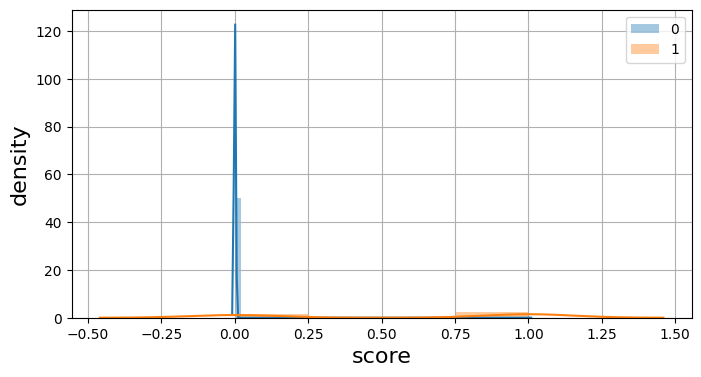

In [34]:
plt.figure(figsize=(8,4))
sns.distplot(y_pred_test_lstm_rnn[y_test==0], label='0')
sns.distplot(y_pred_test_lstm_rnn[y_test==1], label='1')
plt.xlabel('score', fontsize=16)
plt.ylabel('density', fontsize=16)
plt.legend()
plt.grid()

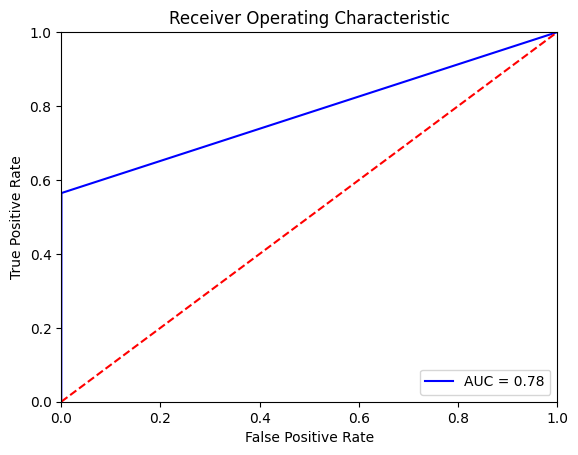

In [35]:
import sklearn.metrics as metrics
preds = y_pred_test_lstm_rnn
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [36]:
print(f'{X_train.shape} {X_val.shape} {X_test.shape}')

(28492, 114) (7123, 114) (8904, 114)


In [ ]:
#RESULTADOS DE LOS MODELOS SUPERVISADOS
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rcParams['figure.figsize'] = (10, 6)
l_m_auc = []
for i,x in enumerate(resulado_final.keys()):
    plot_roc(x, y_test,resulado_final[x] , color=colors[i])
    m_auc = roc_auc_score(y_test,resulado_final[x])
    l_m_auc.append((x,m_auc))
plt.legend();
pd.DataFrame(l_m_auc, columns=['metodo','auc']).sort_values('auc',ascending=False)

## CODIGO VIEJO

In [ ]:
# ARMAMOS DATASET CON REGISTROS ACTUALES PARA TRAIN/VAL/TEST
df = pd.read_parquet(os.path.join(nombre_carpeta, 'data_normal_and_frauds_wide.parquet'))
df = df.rename(columns={'is_fraud':'target','id':'index'})
#Particionar por fecha: Quedan muy desbalanceados los conjuntos
#df_train = df[df.date_fiscalizacion<'2022-09-01'].copy()
#df = pd.read_parquet(os.path.join(nombre_carpeta, 'data_normal_and_frauds_wide.parquet'))
#df = df.rename(columns={'is_fraud':'target','id':'index'})
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# AUMENTAMOS TRAINSET CON FRAUDES DEL DATASET ANTERIOR
df_viejo_fraud = pd.read_parquet(os.path.join(nombre_carpeta+'/viejo/', 'data_fraud_wide.parquet'))
df_viejo_fraud['target']=1
df_viejo_fraud['index']=0
df_train = pd.concat([X_train,y_train],axis=1)
size_remaining = y_train[y_train==0].shape[0] - y_train[y_train==1].shape[0]
cols = list(set(df_train.columns.tolist())-set(['instalacion', 'date_fiscalizacion']))
df_agregar_train = df_viejo_fraud[cols].sample(size_remaining)
df_train_extendido = pd.concat([df_train,df_agregar_train]).reset_index()
df_train_extendido['index'] = list(range(len(df_train_extendido)))
X_train = df_train_extendido.drop('target', axis=1)
y_train = df_train_extendido['target']
df_train_extendido.to_parquet(os.path.join(nombre_carpeta+'/dataset_nuevo_extendido/', 'df_train_extendido.parquet'))
df_train.to_parquet(os.path.join(nombre_carpeta+'/dataset_nuevo_extendido/', 'df_train.parquet'))
#df = pd.read_parquet(os.path.join(nombre_carpeta, 'data_normal_and_frauds_wide_50_50.parquet'))

# AJUSTAMOS LAS DIMENSIONES DE VAL Y TEST: INCORRECTO, YA QUE ESTOY INCLUYENDO REGISTROS VIEJOS
aux = pd.concat([X_val,y_val],axis=1)
no_fraudes = aux[ aux['target']==0 ]
fraudes = aux[ aux['target']==1 ].sample(int(no_fraudes.shape[0]*0.04))
new_X_val = pd.concat([no_fraudes,fraudes])
X_val = new_X_val.drop('target',axis=1)
y_val = new_X_val['target']
aux = pd.concat([X_test,y_test],axis=1)
no_fraudes = aux[ aux['target']==0 ]
fraudes = aux[ aux['target']==1 ].sample(int(no_fraudes.shape[0]*0.04))
new_X_test = pd.concat([no_fraudes,fraudes])
X_test = new_X_test.drop('target',axis=1)
y_test = new_X_test['target']